In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline

In [20]:
def list_images(images, cols = 2, rows = 4, cmap=None):
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

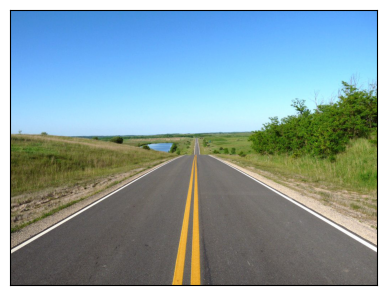

In [21]:
test_images = [plt.imread(img) for img in glob.glob("C:\\Users\\SHANMUGAPRIYAA\\Downloads\\lane 1.jpg.crdownload")]
list_images(test_images)

In [22]:
def RGB_color_selection(image):
    if image.shape[-1] != 3:
        raise ValueError("Input image should have 3 color channels (RGB).")
    lower_threshold = np.array([200, 200, 200], dtype=np.uint8)
    upper_threshold = np.array([255, 255, 255], dtype=np.uint8)
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    lower_threshold = np.array([175, 175, 0], dtype=np.uint8)
    upper_threshold = np.array([255, 255, 255], dtype=np.uint8)
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return masked_image

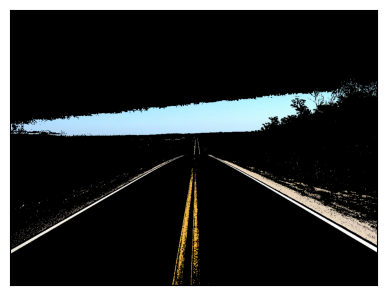

In [23]:
list_images(list(map(RGB_color_selection, test_images)))

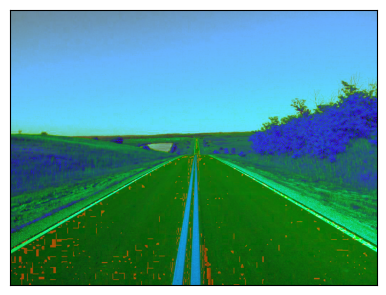

In [24]:
def convert_hsl(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
list_images(list(map(convert_hsl, test_images)))

In [25]:
def HSL_color_selection(image):
    converted_image = convert_hsl(image)
    lower_threshold = np.uint8([0, 200, 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    return masked_image

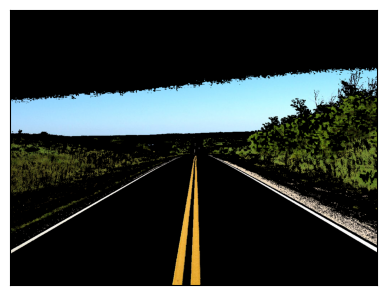

In [26]:
list_images(list(map(HSL_color_selection, test_images)))

In [27]:
color_selected_images = list(map(HSL_color_selection, test_images))

In [28]:
def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

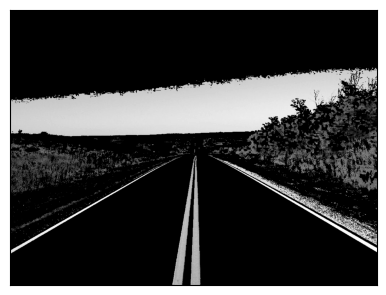

In [29]:
gray_images = list(map(gray_scale, color_selected_images))
list_images(gray_images)

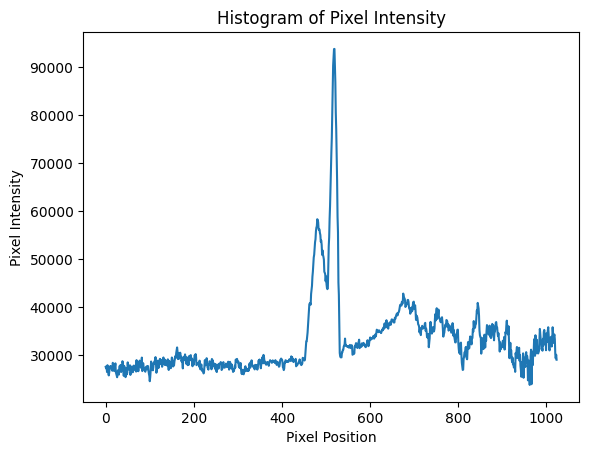

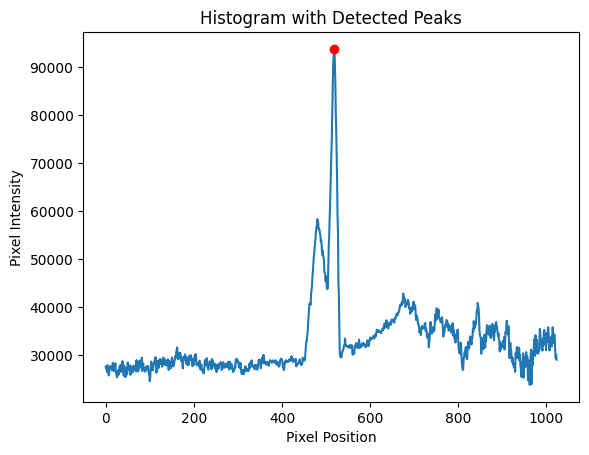

In [30]:
histogram = np.sum(gray_images[0], axis=0)  # Assuming you want to plot the histogram of the first image in gray_images
plt.plot(histogram)
plt.title('Histogram of Pixel Intensity')
plt.xlabel('Pixel Position')
plt.ylabel('Pixel Intensity')
plt.show()


def find_peaks(data, threshold=0.5):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold * np.max(data):
            peaks.append(i)
    return peaks
peak_threshold = 0.7
peaks = find_peaks(histogram, threshold=peak_threshold)
plt.plot(histogram)
plt.plot(peaks, [histogram[p] for p in peaks], 'ro')
plt.title('Histogram with Detected Peaks')
plt.xlabel('Pixel Position')
plt.ylabel('Pixel Intensity')
plt.show()
#print("Detected lane positions at pixel positions:", peaks)

In [108]:
import cv2
import numpy as np
from filterpy.kalman import KalmanFilter
def create_kalman_filter(dim_x, dim_z):
    kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)
    kf.x = np.array([0, 0, 0, 0])
    kf.F = np.array([[1, 1, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 1],
                     [0, 0, 0, 1]])
    kf.H = np.array([[1, 0, 0, 0],
                     [0, 0, 1, 0]])
    measurement_noise = 0.1
    process_noise = 0.01
    kf.R = np.diag([measurement_noise, measurement_noise])
    kf.Q = np.diag([process_noise, process_noise, process_noise, process_noise])
    return kf
kalman_filter = create_kalman_filter(dim_x=4, dim_z=2)
x1, y1 = 100, 200
x2, y2 = 150, 210
x3, y3 = 200, 220
x4, y4 = 250, 230
lane_measurements = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
filtered_lane_positions = []
for measurement in lane_measurements:
    kalman_filter.predict()
    kalman_filter.update(measurement)
    filtered_lane_position = kalman_filter.x[:2]
    filtered_lane_positions.append(filtered_lane_position)
print("Filtered Lane Positions:", filtered_lane_positions)

Filtered Lane Positions: [array([95.26066351, 47.39336493]), array([149.12141481,  52.51955561]), array([200.34436613,  51.8008743 ]), array([250.64205665,  51.15040979])]


In [115]:
def gaussian_smoothing(image, kernel_size = 13):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

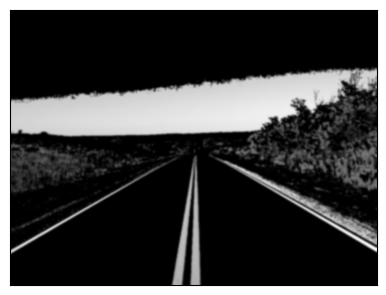

In [116]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

In [117]:
def canny_detector(image, low_threshold = 90, high_threshold = 150):
    return cv2.Canny(image, low_threshold, high_threshold)

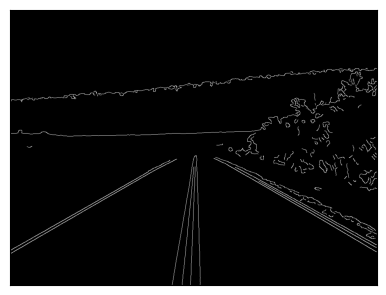

In [118]:
edge_detected_images = list(map(canny_detector, blur_images))
list_images(edge_detected_images)

In [130]:
def region_selection(image):
    mask = np.zeros_like(image)   
    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

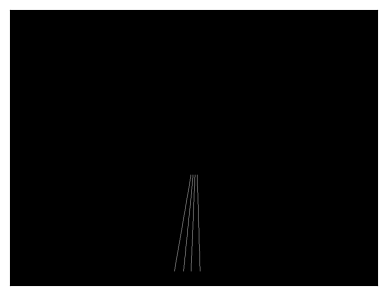

In [131]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

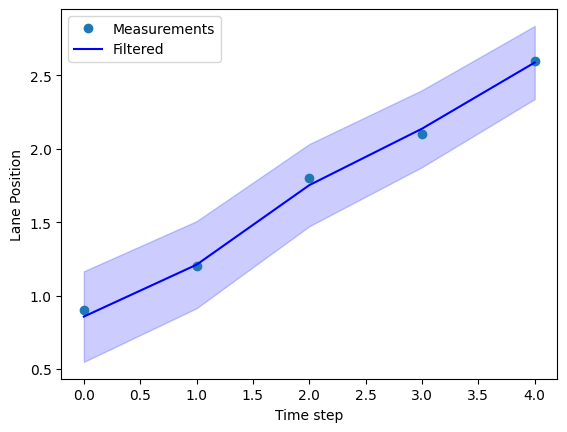

In [155]:
initial_state = np.array([0, 0])  
initial_covariance = np.diag([1, 1]) 
dt = 1.0  
A = np.array([[1, dt], [0, 1]])
H = np.array([1, 0]).reshape(1, 2)
measurement_noise = 0.1
process_noise = 0.01
from filterpy.kalman import KalmanFilter
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = initial_state
kf.P = initial_covariance
kf.F = A
kf.H = H
kf.R = measurement_noise
kf.Q = process_noise
measurements = [0.9, 1.2, 1.8, 2.1, 2.6]
estimated_positions = []
estimated_uncertainties = []
for measurement in measurements:
    kf.predict()
    kf.update(measurement)
    estimated_positions.append(kf.x[0])
    estimated_uncertainties.append(kf.P[0, 0])
plt.figure()
plt.plot(measurements, label='Measurements', marker='o', linestyle='')
plt.plot(estimated_positions, label='Filtered', color='b')
plt.fill_between(range(len(estimated_positions)), [x - np.sqrt(P) for x, P in zip(estimated_positions, estimated_uncertainties)],
                 [x + np.sqrt(P) for x, P in zip(estimated_positions, estimated_uncertainties)], color='b', alpha=0.2)
plt.xlabel('Time step')
plt.ylabel('Lane Position')
plt.legend()
plt.show()

In [152]:
def hough_transform(image):
    rho = 2              
    theta = np.pi/255    
    threshold = 40       
    minLineLength = 80   
    maxLineGap = 90     
    return cv2.HoughLinesP(image, rho=rho, theta=theta, threshold=threshold,
                           minLineLength=minLineLength, maxLineGap=maxLineGap)


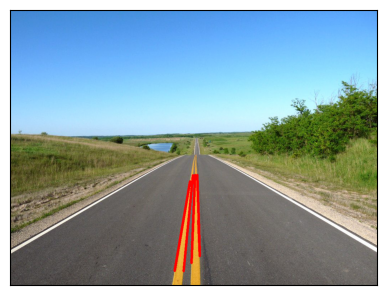

In [153]:
def draw_lines(image, lines, color = [255, 0, 0], thickness = 6):
    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image
line_images = []
for image, lines in zip(test_images, hough_lines):
    if lines is not None:
        line_images.append(draw_lines(image, lines))
list_images(line_images)